# Setup

In [1]:
import os 
from google.colab import drive
import sys


#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/GitHub/INM363-Project'

In [2]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update &> /dev/null


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip &> /dev/null

# Boost libraries
apt-get install libboost-all-dev &> /dev/null


In [3]:
!pip install vizdoom --quiet 
!pip install ray  --quiet
!pip install ray['rllib'] --quiet
!pip install Ipython --upgrade --quiet

In [4]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward

In [5]:
from ray.tune.registry import register_env
import gym
import os
import ray
import ray.rllib.agents.ppo as ppo
from ray.rllib.algorithms.callbacks import RE3UpdateCallbacks
import src.helper_fuctions as helper
import shutil
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from fnmatch import fnmatch 
import numpy as np
sns.set()

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Initialize Ray

In [7]:
ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =2, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")

Shutdown ray


2022-09-28 06:35:12,361	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


# ICM 

In [8]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
#config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = True
config['in_evaluation'] = True

config["num_workers"] = 0 

config["exploration_config"] = {
    "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    "eta": 0.01, #0.001,  # Weight for intrinsic rewards before being added to extrinsic ones.
    "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    # Setup of the feature net (used to encode observations into feature (latent) vectors).
    "feature_net_config": {
        "fcnet_hiddens": [],
        "fcnet_activation": "relu",
    },
    "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    "forward_net_activation": "relu",  # Activation of the "forward" model.
    "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    # Specify, which exploration sub-type to use (usually, the algo's "default"
    # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
   
    "sub_exploration": {
#        "type": "EpsilonGreedy",
#        "initial_epsilon": 1.0, #0.01,
#        "final_epsilon": 0.01, #0.001
        "type": "StochasticSampling",
        
    }
}
#config["vf_clip_param"] = 400
icm_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

2022-09-28 06:35:14,101	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-09-28 06:35:14,112	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


2022-09-28 06:35:14,906	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-28 06:35:20,715	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [9]:
#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizdoomMyWayHome-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizDoomVeryDenseReward-v0
  logger.warn(f"Overriding environment {id}")


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [10]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))

#chkpt_mean_rewards = [] 
#chkpt_me

icm_chkpt_mean_rewards = np.array([]) 
icm_chkpt_std_rewards = np.array([]) 
icm_chkpt_mean_steps = np.array([]) 
icm_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  icm_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 500# 200

    for step in range(n_step):
          action = icm_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  icm_chkpt_mean_rewards = np.append(icm_chkpt_mean_rewards, np.mean(total_reward) )
  icm_chkpt_std_rewards = np.append(icm_chkpt_std_rewards, np.std(total_reward))
  icm_chkpt_mean_steps = np.append(icm_chkpt_mean_steps, np.mean(total_steps))
  icm_chkpt_std_steps = np.append(icm_chkpt_std_steps, np.std(total_steps))



2022-09-28 06:35:21,686	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000001
2022-09-28 06:35:21,700	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 71.21451878547668, '_episodes_total': 10}
2022-09-28 06:35:21,709	WARNING deprecation.py:48 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


Total number of checkpoints:  29
checkpoint_000001


2022-09-28 06:35:35,847	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000020
2022-09-28 06:35:35,852	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1405.334727048874, '_episodes_total': 200}


checkpoint_000020


2022-09-28 06:35:43,539	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000040
2022-09-28 06:35:43,543	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2801.577687740326, '_episodes_total': 402}


checkpoint_000040


2022-09-28 06:35:51,357	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000060
2022-09-28 06:35:51,359	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 4201.6350865364075, '_episodes_total': 610}


checkpoint_000060


2022-09-28 06:35:59,131	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000080
2022-09-28 06:35:59,133	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 5595.630488872528, '_episodes_total': 832}


checkpoint_000080


2022-09-28 06:36:07,106	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000100
2022-09-28 06:36:07,107	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 6994.142407655716, '_episodes_total': 1064}


checkpoint_000100


2022-09-28 06:36:15,011	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000120
2022-09-28 06:36:15,012	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 8384.49707365036, '_episodes_total': 1294}


checkpoint_000120


2022-09-28 06:36:22,972	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000140
2022-09-28 06:36:22,973	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 9766.710532426834, '_episodes_total': 1528}


checkpoint_000140


2022-09-28 06:36:30,871	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000160
2022-09-28 06:36:30,875	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 11143.99144411087, '_episodes_total': 1750}


checkpoint_000160


2022-09-28 06:36:38,761	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000180
2022-09-28 06:36:38,763	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 12522.29850101471, '_episodes_total': 1987}


checkpoint_000180


2022-09-28 06:36:46,805	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000200
2022-09-28 06:36:46,810	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 13916.559031963348, '_episodes_total': 2219}


checkpoint_000200


2022-09-28 06:36:56,278	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000210
2022-09-28 06:36:56,288	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 14674.811937093735, '_episodes_total': 2336}


checkpoint_000210


2022-09-28 06:37:04,135	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000240
2022-09-28 06:37:04,136	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 16928.54078936577, '_episodes_total': 2687}


checkpoint_000240


2022-09-28 06:37:12,074	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000270
2022-09-28 06:37:12,076	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 19169.015046596527, '_episodes_total': 3043}


checkpoint_000270


2022-09-28 06:37:22,256	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000300
2022-09-28 06:37:22,258	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 21420.54273366928, '_episodes_total': 3392}


checkpoint_000300


2022-09-28 06:37:30,288	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000330
2022-09-28 06:37:30,290	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 330, '_timesteps_total': None, '_time_total': 23672.552119731903, '_episodes_total': 3742}


checkpoint_000330


2022-09-28 06:37:38,347	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000360
2022-09-28 06:37:38,349	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 25945.922863721848, '_episodes_total': 4097}


checkpoint_000360


2022-09-28 06:37:45,670	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000390
2022-09-28 06:37:45,671	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 390, '_timesteps_total': None, '_time_total': 28206.684782981873, '_episodes_total': 4440}


checkpoint_000390


2022-09-28 06:37:53,615	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000420
2022-09-28 06:37:53,621	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 30471.036967992783, '_episodes_total': 4779}


checkpoint_000420


2022-09-28 06:38:03,186	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000440
2022-09-28 06:38:03,188	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 32062.208126544952, '_episodes_total': 5003}


checkpoint_000440


2022-09-28 06:38:17,944	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000480
2022-09-28 06:38:17,948	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 35250.83441615105, '_episodes_total': 5456}


checkpoint_000480


2022-09-28 06:38:25,788	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000520
2022-09-28 06:38:25,790	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 38434.35478377342, '_episodes_total': 5906}


checkpoint_000520


2022-09-28 06:38:35,790	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000560
2022-09-28 06:38:35,793	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 560, '_timesteps_total': None, '_time_total': 41634.81606912613, '_episodes_total': 6348}


checkpoint_000560


2022-09-28 06:38:43,655	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000600
2022-09-28 06:38:43,656	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 44863.86438751221, '_episodes_total': 6798}


checkpoint_000600


2022-09-28 06:38:51,500	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000640
2022-09-28 06:38:51,501	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 48073.38787198067, '_episodes_total': 7239}


checkpoint_000640


2022-09-28 06:38:59,467	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000680
2022-09-28 06:38:59,469	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 680, '_timesteps_total': None, '_time_total': 51253.891367435455, '_episodes_total': 7679}


checkpoint_000680


2022-09-28 06:39:07,547	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000720
2022-09-28 06:39:07,549	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 720, '_timesteps_total': None, '_time_total': 54454.61078572273, '_episodes_total': 8127}


checkpoint_000720


2022-09-28 06:39:15,110	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000760
2022-09-28 06:39:15,112	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 760, '_timesteps_total': None, '_time_total': 57629.062733888626, '_episodes_total': 8570}


checkpoint_000760


2022-09-28 06:39:24,240	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000800
2022-09-28 06:39:24,242	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 60802.57106924057, '_episodes_total': 9009}


checkpoint_000800


In [11]:
#read first results file 
results_pth = chkpt_root + '/' + 'result.csv'
icm_df = pd.read_csv(results_pth) 

#cumulative sum of episodes
icm_df['eps_cumsum'] = icm_df['episodes_this_iter'].cumsum()
icm_df = icm_df[['checkpoint', 'eps_cumsum']]
icm_df.checkpoint = icm_df['checkpoint'].astype(int)
icm_df.head()

,checkpoint,eps_cumsum
0,1,10.0
1,2,20.0
2,3,30.0
3,4,40.0
4,5,50.0


In [12]:
icm_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  #print(chkpt_int)
  eps_num = icm_df[~(icm_df['eps_cumsum'].where(icm_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  icm_cum_eps.append(eps_num)

print(f"Total episodes: {icm_cum_eps}")
print(f"Mean reward: {icm_chkpt_mean_rewards}")
print(f"Std reward: {icm_chkpt_std_rewards}")
print(f"Mean steps: {icm_chkpt_mean_steps}")
print(f"Std steps: {icm_chkpt_std_steps}")

#check length of lists are the same 
#assert len(icm_cum_eps) == len(icm_chkpt_mean_rewards)
#assert len(icm_cum_eps) == len(icm_chkpt_mean_steps)

Total episodes: [10.0, 200.0, 402.0, 610.0, 832.0, 1064.0, 1294.0, 1528.0, 1750.0, 1987.0, 2219.0, 2336.0, 2687.0, 3043.0, 3392.0, 3742.0, 4097.0, 4440.0, 4779.0, 5003.0, 5456.0, 5906.0, 6348.0, 6798.0, 7239.0, 7679.0, 8127.0, 8570.0, 9009.0]
Mean reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
Std reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
Mean steps: [200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.  200.
 200.  200.  200.  200.  184.3 200.  187.2 198.3 200.  191.6 200.  200.
 200.  200.  188.2 200.  175.6]
Std steps: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         36.70435941  0.
 38.4         5.1         0.         25.2         0.          0.
  0.          0.         35.4         0.         48.87371482]


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## ICM avg reward

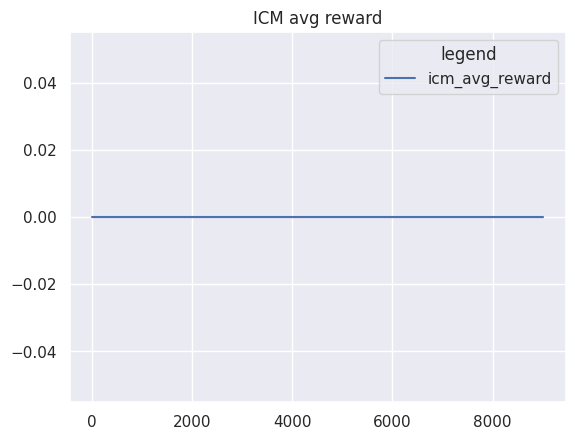

In [13]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'b-', label='icm_avg_reward')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), 
                 (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg reward") 
plt.show()



## ICM avg steps

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


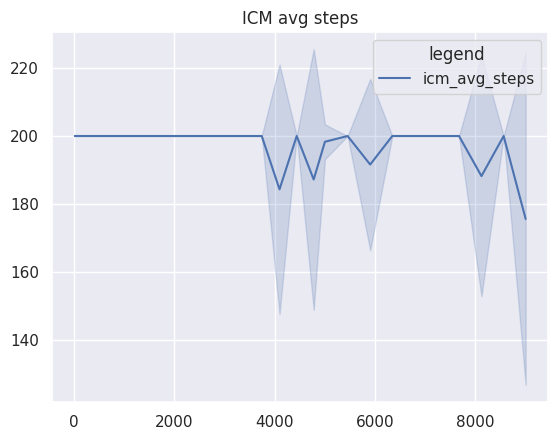

In [14]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'b-', label='icm_avg_steps')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), 
                 (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg steps") 
plt.show()



## ICM shortest Path

In [15]:
#max_mean_rewards_idx = np.argmax(icm_chkpt_mean_rewards)
max_mean_rewards_idx = np.argmin(icm_chkpt_mean_steps)

eps_itr = icm_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = icm_df[~(icm_df["eps_cumsum"].where(icm_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[0]
print("Best checkpoint: ", best_chkpt)

9009.0
Best checkpoint:  800


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward" 
chkpt_dir = "checkpoint_000" + str(best_chkpt)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000800'

In [17]:
icm_agent.restore(chkpt_pth)

2022-09-28 06:39:32,044	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/no_reward/checkpoint_000800
2022-09-28 06:39:32,048	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 60802.57106924057, '_episodes_total': 9009}


cumulative reward 0.0
total steps: 199
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
Health Bonus locations: []
Armor location: [(-800.0, -160.0)]
Sector locations: [(-640.0, -704.0, 32.0, 32.0), (-704.0, -640.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-640.0, -640.0, -256.0, -224.0), (-448.0, -640.0, -256.0, -256.0), (-448.0, -448.0, -64.0, -256.0), (-640.0, -608.0, -64.0, -64.0), (-480.0, -448.0, -64.0, -64.0), (-640.0, -640.0, -96.0, -64.0), (-640.0, -640.0, 0.0, 32.0), (-448.0, -480.0, 0.0, 0.0), (-640.0, -640.0, 160.0, 192.0), (-608.0, -640.0, 0.0, 0.0), (-448.0, -448.0, 192.0, 0.0), (-640.0, -608.0, 192.0, 192.0), (-480.0, -448.0, 192.0, 192.0), (-480.0, -480.0, 0.0, -64.0), (-608.0, -608.0, -64.0, 0.0), (-448.0, -480.0, 256.0, 256.0), (-448.0, -448.0, 448.0, 256.0), (-640.0, -44

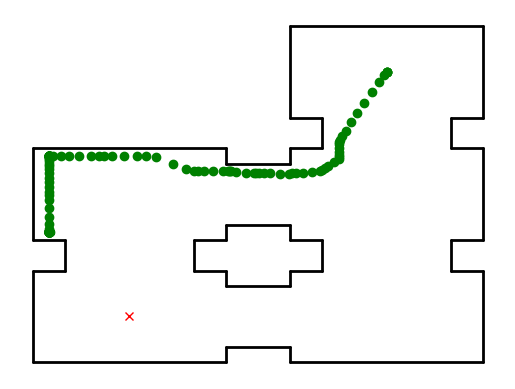

In [18]:
state = env.reset()
sum_reward = 0
n_step = 200
icm_path = [] 

for step in range(n_step):
    action = icm_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      icm_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/test/no_reward_fixed_start.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, icm_path)


## ICM Goal Accomplishment

In [19]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200
    counter = 0 

    for step in range(n_step):
        action = icm_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
        counter +=1
      
        if done == 1:
          break 

    if counter < n_step:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 3 / 100


# RE3

In [20]:
class RE3Callbacks(RE3UpdateCallbacks, config["callbacks"]):
  pass

In [21]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['explore'] = True 
config['in_evaluation'] = True
config["framework"] = "tf"
config["seed"] = 12345
config["callbacks"] = RE3Callbacks
config["exploration_config"] = {
    "type": "RE3",
     "embeds_dim": 128,
     "rho": 0.1, # Beta decay factor, used for on-policy algorithm.
     "k_nn": 7, # Number of neighbours to set for K-NN entropy estimation.
     "encoder_net_config": {
         "fcnet_hiddens": [],
         "fcnet_activation": "relu",
     },
     # `reward = r + beta * intrinsic_reward`
     "beta": 0.2,
     # Schedule to use for beta decay, one of constant" or "linear_decay".
     "beta_schedule": 'constant',
     # Specify, which exploration sub-type to use (usually, the algo's "default"
     # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
     "sub_exploration": {
         "type": "StochasticSampling",
     }
}
re3_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


(RolloutWorker pid=14264) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=14264) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
(RolloutWorker pid=14264) episode timeout: 800
(RolloutWorker pid=14264) screen resolution: 320X240
(RolloutWorker pid=14265) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=14265) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
(RolloutWorker pid=14265) episode timeout: 800
(RolloutWorker pid=14265) screen resolution: 320X240


(RolloutWorker pid=14264) 2022-09-28 06:40:59,929	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=14264) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=14264)   "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
(RolloutWorker pid=14265) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=14265)   "Function `env.seed(seed)` is marked as deprecated and will be remove

created agent


In [22]:
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [23]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))


re3_chkpt_mean_rewards = np.array([]) 
re3_chkpt_std_rewards = np.array([]) 
re3_chkpt_mean_steps = np.array([]) 
re3_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  re3_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 500#200

    for step in range(n_step):
          action = re3_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  re3_chkpt_mean_rewards = np.append(re3_chkpt_mean_rewards, np.mean(total_reward) )
  re3_chkpt_std_rewards = np.append(re3_chkpt_std_rewards, np.std(total_reward))
  re3_chkpt_mean_steps = np.append(re3_chkpt_mean_steps, np.mean(total_steps))
  re3_chkpt_std_steps = np.append(re3_chkpt_std_steps, np.std(total_steps))



2022-09-28 06:41:06,766	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000001
2022-09-28 06:41:06,767	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 59.64373970031738, '_episodes_total': 10}


Total number of checkpoints:  29
checkpoint_000001


2022-09-28 06:41:14,841	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000020
2022-09-28 06:41:14,843	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1052.0773894786835, '_episodes_total': 239}


checkpoint_000020


2022-09-28 06:41:22,640	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000040
2022-09-28 06:41:22,647	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2097.0832118988037, '_episodes_total': 487}


checkpoint_000040


2022-09-28 06:41:30,271	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000060
2022-09-28 06:41:30,272	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3145.3052203655243, '_episodes_total': 721}


checkpoint_000060


2022-09-28 06:41:38,246	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000080
2022-09-28 06:41:38,249	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4196.636046409607, '_episodes_total': 969}


checkpoint_000080


2022-09-28 06:41:45,899	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000100
2022-09-28 06:41:45,900	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5243.151789188385, '_episodes_total': 1212}


checkpoint_000100


2022-09-28 06:41:53,787	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000120
2022-09-28 06:41:53,790	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 6283.652190208435, '_episodes_total': 1453}


checkpoint_000120


2022-09-28 06:42:01,388	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000140
2022-09-28 06:42:01,392	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 7330.023674726486, '_episodes_total': 1692}


checkpoint_000140


2022-09-28 06:42:09,114	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000160
2022-09-28 06:42:09,116	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 8375.345492124557, '_episodes_total': 1926}


checkpoint_000160


2022-09-28 06:42:16,585	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000180
2022-09-28 06:42:16,589	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 9417.185512304306, '_episodes_total': 2164}


checkpoint_000180


2022-09-28 06:42:24,345	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000200
2022-09-28 06:42:24,347	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 10467.188096284866, '_episodes_total': 2399}


checkpoint_000200


2022-09-28 06:42:32,063	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000210
2022-09-28 06:42:32,065	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 11010.728949308395, '_episodes_total': 2526}


checkpoint_000210


2022-09-28 06:42:39,853	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000240
2022-09-28 06:42:39,856	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 12609.783692598343, '_episodes_total': 2870}


checkpoint_000240


2022-09-28 06:42:46,812	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000270
2022-09-28 06:42:46,816	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 14163.972209215164, '_episodes_total': 3231}


checkpoint_000270


2022-09-28 06:42:54,720	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000300
2022-09-28 06:42:54,721	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 15699.214765548706, '_episodes_total': 3581}


checkpoint_000300


2022-09-28 06:43:02,594	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000330
2022-09-28 06:43:02,598	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 330, '_timesteps_total': None, '_time_total': 17229.22200679779, '_episodes_total': 3925}


checkpoint_000330


2022-09-28 06:43:10,527	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000360
2022-09-28 06:43:10,529	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 18757.969670772552, '_episodes_total': 4272}


checkpoint_000360


2022-09-28 06:43:18,406	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000390
2022-09-28 06:43:18,415	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 390, '_timesteps_total': None, '_time_total': 20283.881762981415, '_episodes_total': 4621}


checkpoint_000390


2022-09-28 06:43:26,380	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000420
2022-09-28 06:43:26,383	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 21812.800235271454, '_episodes_total': 4965}


checkpoint_000420


2022-09-28 06:43:33,351	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000440
2022-09-28 06:43:33,361	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 22878.526338338852, '_episodes_total': 5201}


checkpoint_000440


2022-09-28 06:43:43,595	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000480
2022-09-28 06:43:43,605	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 24991.860086917877, '_episodes_total': 5666}


checkpoint_000480


2022-09-28 06:43:51,350	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000520
2022-09-28 06:43:51,353	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 27095.303891420364, '_episodes_total': 6120}


checkpoint_000520


2022-09-28 06:43:58,946	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000560
2022-09-28 06:43:58,947	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 560, '_timesteps_total': None, '_time_total': 29201.523087739944, '_episodes_total': 6580}


checkpoint_000560


2022-09-28 06:44:06,690	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000600
2022-09-28 06:44:06,692	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 31308.722942590714, '_episodes_total': 7051}


checkpoint_000600


2022-09-28 06:44:14,022	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000640
2022-09-28 06:44:14,024	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 33413.280532836914, '_episodes_total': 7517}


checkpoint_000640


2022-09-28 06:44:21,813	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000680
2022-09-28 06:44:21,815	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 680, '_timesteps_total': None, '_time_total': 35533.53641843796, '_episodes_total': 7974}


checkpoint_000680


2022-09-28 06:44:29,672	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000720
2022-09-28 06:44:29,674	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 720, '_timesteps_total': None, '_time_total': 37654.52862119675, '_episodes_total': 8430}


checkpoint_000720


2022-09-28 06:44:36,846	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000760
2022-09-28 06:44:36,848	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 760, '_timesteps_total': None, '_time_total': 39783.86891722679, '_episodes_total': 8888}


checkpoint_000760


2022-09-28 06:44:44,509	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000800
2022-09-28 06:44:44,511	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 41944.859322309494, '_episodes_total': 9327}


checkpoint_000800


In [24]:
#read first results file 
results_pth = chkpt_root + '/' + 'result.csv'
re3_df = pd.read_csv(results_pth) 

#cumulative sum of episodes
re3_df['eps_cumsum'] = re3_df['episodes_this_iter'].cumsum()
re3_df = re3_df[['checkpoint', 'eps_cumsum']]
re3_df.checkpoint = re3_df['checkpoint'].astype(int)
re3_df.tail()

,checkpoint,eps_cumsum
815,816,9510.0
816,817,9520.0
817,818,9532.0
818,819,9545.0
819,820,9556.0


In [25]:
re3_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = re3_df[~(re3_df['eps_cumsum'].where(re3_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  re3_cum_eps.append(eps_num)

print(f"Total episodes: {re3_cum_eps}")
print(f"Mean reward: {re3_chkpt_mean_rewards}")
print(f"Std reward: {re3_chkpt_std_rewards}")
print(f"Mean steps: {re3_chkpt_mean_steps}")
print(f"Std steps: {re3_chkpt_std_steps}")

#check length of lists are the same 
assert len(re3_cum_eps) == len(re3_chkpt_mean_rewards)
assert len(re3_cum_eps) == len(re3_chkpt_mean_steps)

Total episodes: [10.0, 239.0, 487.0, 721.0, 969.0, 1212.0, 1453.0, 1692.0, 1926.0, 2164.0, 2399.0, 2526.0, 2870.0, 3231.0, 3581.0, 3925.0, 4272.0, 4621.0, 4965.0, 5201.0, 5666.0, 6120.0, 6580.0, 7051.0, 7517.0, 7974.0, 8430.0, 8888.0, 9327.0]
Mean reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
Std reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
Mean steps: [200.  200.  193.4 199.8 195.5 200.  196.8 200.  191.7 200.  200.  200.
 179.8 197.9 200.  200.  200.  200.  175.  194.2 200.  194.8 200.  189.8
 200.  200.  184.4 200.  200. ]
Std steps: [ 0.          0.         19.8         0.6        13.5         0.
  9.6         0.         16.61354869  0.          0.          0.
 41.47722266  6.3         0.          0.          0.          0.
 50.00799936 12.6         0.         15.6         0.         30.6
  0.          0.         31.7370446   0.          0.        ]


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## RE3 avg reward

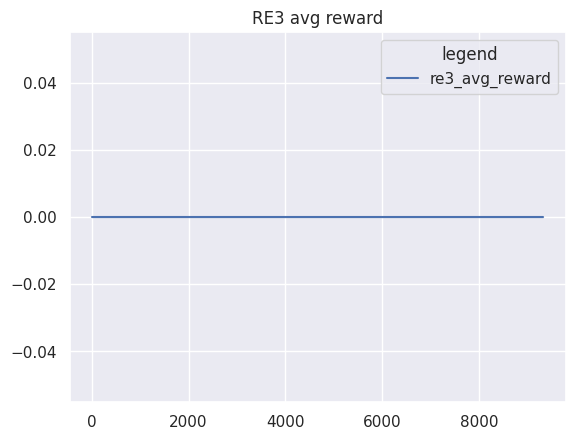

In [26]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_rewards, 'b-', label='re3_avg_reward')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_rewards - re3_chkpt_std_rewards), (re3_chkpt_mean_rewards + re3_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg reward") 
plt.show()



## RE3 avg steps

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


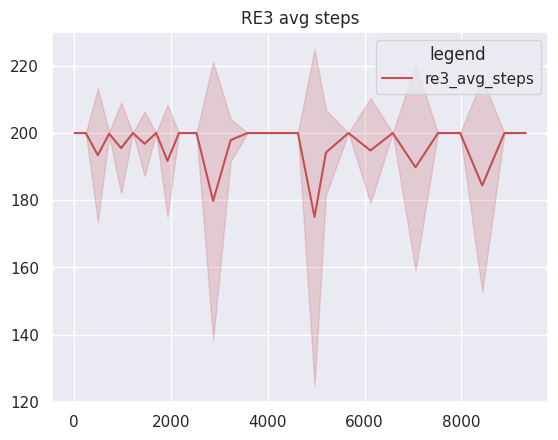

In [27]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_steps, 'r-', label='re3_avg_steps')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_steps - re3_chkpt_std_steps), (re3_chkpt_mean_steps + re3_chkpt_std_steps), color='r', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg steps") 
plt.show()



## RE3 Path

In [28]:
#max_mean_rewards_idx = np.argmax(re3_chkpt_mean_rewards)
max_mean_rewards_idx = np.argmin(re3_chkpt_mean_steps)
eps_itr = re3_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = re3_df[~(re3_df["eps_cumsum"].where(re3_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[-1]
print("Best checkpoint: ", best_chkpt)

4965.0
Best checkpoint:  420


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward" 
chkpt_dir = "checkpoint_000" + str(best_chkpt)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000420'

In [30]:
re3_agent.restore(chkpt_pth)

2022-09-28 06:44:52,917	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/no_reward/checkpoint_000420
2022-09-28 06:44:52,925	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 21812.800235271454, '_episodes_total': 4965}


cumulative reward 0.0
total steps: 199
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/no_reward_fixed_start.wad
Health Bonus locations: []
Armor location: [(-800.0, -160.0)]
Sector locations: [(-640.0, -704.0, 32.0, 32.0), (-704.0, -640.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-640.0, -640.0, -256.0, -224.0), (-448.0, -640.0, -256.0, -256.0), (-448.0, -448.0, -64.0, -256.0), (-640.0, -608.0, -64.0, -64.0), (-480.0, -448.0, -64.0, -64.0), (-640.0, -640.0, -96.0, -64.0), (-640.0, -640.0, 0.0, 32.0), (-448.0, -480.0, 0.0, 0.0), (-640.0, -640.0, 160.0, 192.0), (-608.0, -640.0, 0.0, 0.0), (-448.0, -448.0, 192.0, 0.0), (-640.0, -608.0, 192.0, 192.0), (-480.0, -448.0, 192.0, 192.0), (-480.0, -480.0, 0.0, -64.0), (-608.0, -608.0, -64.0, 0.0), (-448.0, -480.0, 256.0, 256.0), (-448.0, -448.0, 448.0, 256.0), (-640.0, -44

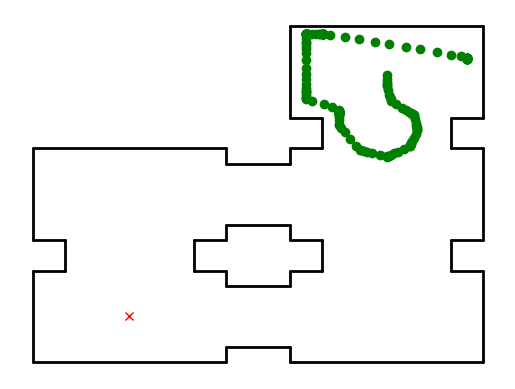

In [31]:
state = env.reset()
sum_reward = 0
n_step = 200
re3_path = [] 

for step in range(n_step):
    action = re3_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      re3_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")


sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/test/no_reward_fixed_start.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, re3_path)


## RE3 Goal Accomplishment

In [32]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200
    counter = 0 

    for step in range(n_step):
        action = re3_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
        counter += 1
      
        if done == 1:
          break 

    if counter < n_step:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 3 / 100


# All graphs

## All Paths

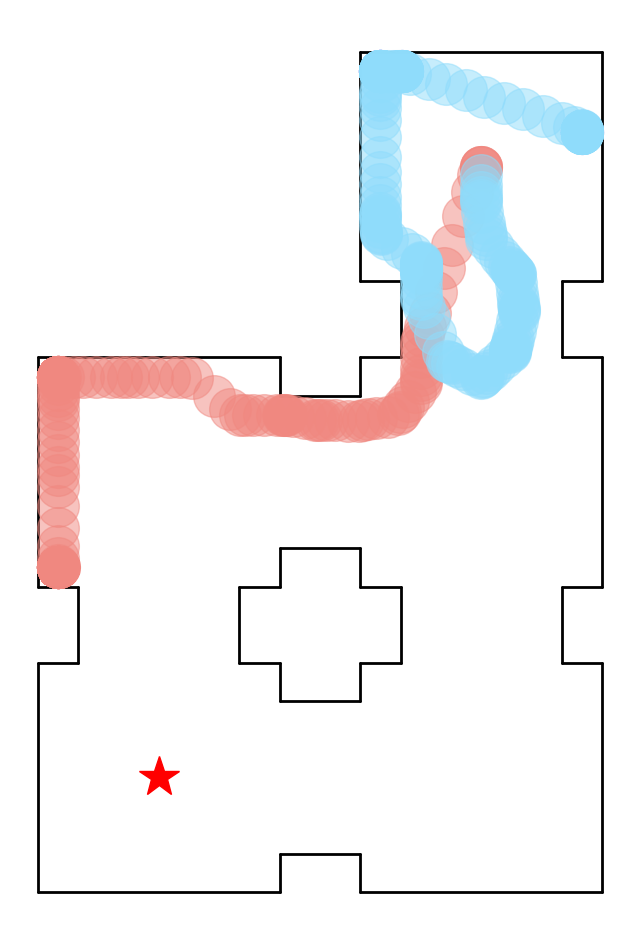

In [33]:
plt.rcParams["figure.figsize"] = (8, 12)

for sector in sectors:
        plt.plot([sector[0], sector[1]], [sector[2], sector[3]], color='black', linewidth=2)

# plot path taken
#for pos in ppo_path:
#    plt.plot(pos[0], pos[1], color='#B5E7B5', marker='o', markersize = 30, alpha = 0.5)
for pos in icm_path:
    plt.plot(pos[0], pos[1], color='#F08880', marker='o', markersize = 30, alpha = 0.5)
for pos in re3_path:
    plt.plot(pos[0], pos[1], color='#8FDCFB', marker='o', markersize=30, alpha = 0.5)

#'#2E75B6'
    

# plot positions of health bonus and armor:
for pos in health_pos:
    plt.plot(pos[0], pos[1], color='k', marker='X', markersize = 20)
for pos in armor_pos:
    plt.plot(pos[0], pos[1], color='red', marker='*', markersize = 30)

plt.axis("off")
plt.show()


## Average Reward

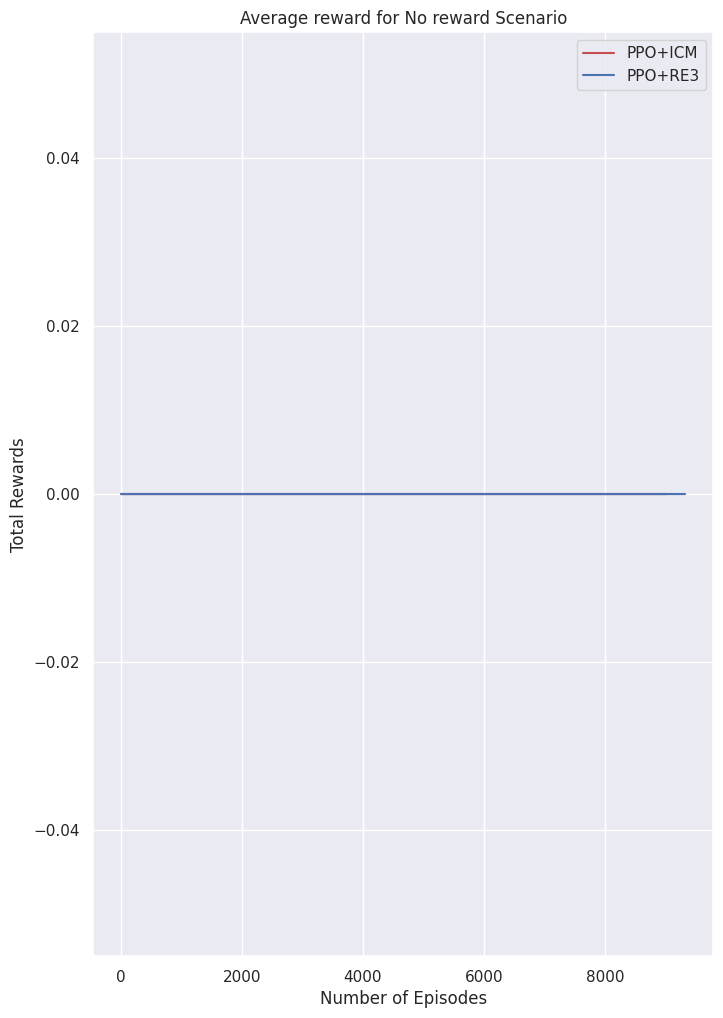

In [34]:

#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='r', alpha=0.2) 
#RE3
plt.plot(re3_cum_eps, re3_chkpt_mean_rewards, 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_rewards - re3_chkpt_std_rewards), (re3_chkpt_mean_rewards + re3_chkpt_std_rewards), color='b', alpha=0.2) 


plt.legend() #title='legend'
plt.xlabel('Number of Episodes') 
plt.ylabel('Total Rewards') 
plt.title("Average reward for No reward Scenario") 
plt.show()


## Average Steps

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


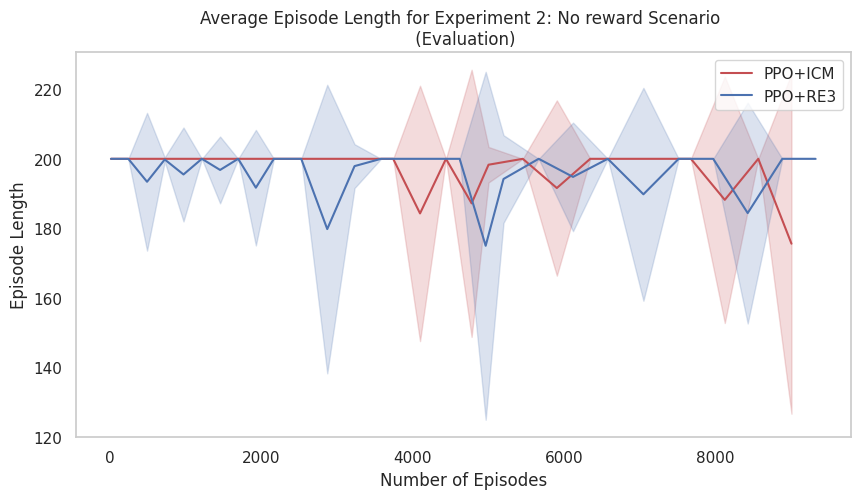

In [35]:
plt.rcParams["figure.figsize"] = (10,5)
sns.set_style("whitegrid", {'axes.grid' : False})

#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='r', alpha=0.2) 

#RE3
plt.plot(re3_cum_eps, re3_chkpt_mean_steps, 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_steps - re3_chkpt_std_steps), (re3_chkpt_mean_steps + re3_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend()
plt.title("Average Episode Length for Experiment 2: No reward Scenario \n (Evaluation)") 
plt.xlabel('Number of Episodes') 
plt.ylabel('Episode Length') 
plt.show()

# Save results file

In [36]:
from pathlib import Path 
root = "/content/drive/MyDrive/GitHub/INM363-Project/results" 
cols = ["episodes", "mean_reward", "std_reward", "mean_steps", "std_steps"]

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## ICM

In [37]:
fname = "/E2_icm_no_reward.csv"

df_icm = pd.DataFrame(columns = cols)
df_icm["episodes"] = icm_cum_eps
df_icm["mean_reward"] = icm_chkpt_mean_rewards
df_icm["std_reward"] = icm_chkpt_std_rewards
df_icm["mean_steps"] = icm_chkpt_mean_steps
df_icm["std_steps"] = icm_chkpt_std_steps

fpath = Path(root + fname)
df_icm.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_icm.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E2_icm_no_reward.csv


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,10.0,0.0,0.0,200.0,0.0
1,200.0,0.0,0.0,200.0,0.0
2,402.0,0.0,0.0,200.0,0.0
3,610.0,0.0,0.0,200.0,0.0
4,832.0,0.0,0.0,200.0,0.0


## RE3

In [38]:
fname = "/E2_re3_no_reward.csv"

df_re3 = pd.DataFrame(columns = cols)
df_re3["episodes"] = re3_cum_eps
df_re3["mean_reward"] = re3_chkpt_mean_rewards
df_re3["std_reward"] = re3_chkpt_std_rewards
df_re3["mean_steps"] = re3_chkpt_mean_steps
df_re3["std_steps"] = re3_chkpt_std_steps

fpath = Path(root + fname)
df_re3.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_re3.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E2_re3_no_reward.csv


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,10.0,0.0,0.0,200.0,0.0
1,239.0,0.0,0.0,200.0,0.0
2,487.0,0.0,0.0,193.4,19.8
3,721.0,0.0,0.0,199.8,0.6
4,969.0,0.0,0.0,195.5,13.5


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
